In [3]:
import os,sys
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs("runs/classifier-eval", exist_ok=True)
sys.path.append("../")

from datasets.data_utils import get_dataset, get_dataloader
from ourddpm import OurDDPM
from utils.image_utils import fuse, normalize
from main import dict2namespace
import argparse
import yaml
import warnings
warnings.filterwarnings(action='ignore')
from PIL import Image
import cv2
from tqdm import tqdm


import torch
import pickle
import torchvision.utils as tvu
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# # parser = argparse.ArgumentParser(description='.')
# # parser.add_argument('img_index', metavar='N', type=int, nargs=1,
# #                     help='index of the image')
# # args = parser.parse_args()

def get_scheduler(s):
    scheduler = set()
    periods = s.split(",")
    for p in periods:
        l = int(p.split("-")[0])
        r = int(p.split("-")[1])
        for i in range(l, r):
            scheduler.add(i)
    return scheduler


model_path = os.path.join("pretrained/celeba_hq.ckpt")

exp_dir = f"runs/classifier_test"
os.makedirs(exp_dir, exist_ok=True)

# img_index = args.img_index[0]
n_step =  999#@param {type: "integer"}
sampling = "ddpm" #@param ["ddpm", "ddim"]
fixed_xt = True #@param {type: "boolean"}
add_var = True #@param {type: "boolean"}
add_var_on = "0-999" #@param {type: "string"}
vis_gen =  True #@param {type: "boolean"}
guidance_on  = "800-999"

var_scheduler = get_scheduler(add_var_on)
guidance_scheduler = get_scheduler(guidance_on)

args_dic = {
    'config': 'celeba.yml', 
    'n_step': int(n_step), 
    'sample_type': sampling, 
    'eta': 0.0,
    'bs_train': 1, 
    'model_path': model_path, 
    'hybrid_noise': 0, 
    'align_face': 0,
    'image_folder': exp_dir,
    'add_var': bool(add_var),
    'add_var_on': add_var_on,
    'guidance_scheduler': guidance_scheduler
    }
args = dict2namespace(args_dic)

with open(os.path.join('../configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)

device = torch.device("cuda")

config.device = device
runner = OurDDPM(args, config, device=device)
runner.load_classifier("../checkpoint/attr_classifier_4_attrs_150.pt", feature_num=4)

data_root = "/home/summertony717/data/celeba_hq"
train_dataset, val_dataset, test_dataset = get_dataset("CelebA_HQ", data_root, runner.config)#, label = "../DMP_data/list_attr_celeba.csv.zip")

def test_loader(dataset, i):
    img, _ = np.array(dataset[i])
    ts = torch.zeros(1).cuda()
    img = torch.tensor(img).reshape(1, *img.shape)
    return img, ts


In [ ]:
# res = []
# with torch.no_grad():
#     for i in tqdm(range(len(test_dataset))):
#         img, ts = test_loader(test_dataset, i)
#         output = runner.classifier(img.cuda(), timesteps=ts)
#         logits = F.sigmoid(output)
#         res.append((i, logits[0]))


# with open("temp.pkl", "wb") as f:
#     pickle.dump(res, f)

In [5]:
res = []
with open("../temp.pkl", "rb") as f:
    res = pickle.load(f)

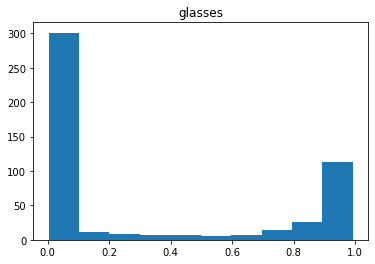

In [14]:
for i in [3]:
# for i in range(4):
    val_id = [(b[i].item(), a) for a, b in res]
    val_id.sort()

    vals = [e[0] for e in val_id]
    plt.figure()
    plt.title("glasses")
    plt.hist(vals)